# Tracking Frequency, Phase, and Amplitude

In recent weeks, we have learned how to find the start of the signal and how to obtain initial estimates for amplitude, frequency, and phase errors. These initial estimates must be maintained throughout the reception of a signal frame. Of particular concern is a residual frequency error that leads to a build-up of phase error over time.

Today, we show how feedback control systems can be used to maintain accurate estimates - even if the true signal parameters are changing with time. The feedback control system for tracking the phase of the incoming signal is called a phase-locked loop.

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/070_tracking_loops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/070_tracking_loops.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

from typing import Tuple

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

## Phase-Locked Loops

A phase-locked loop aims to generate an estimate of the phase $\hat{\phi}[n]$ of the received signal $Z_n$; specifically, $Z_n$ is the output of the matched filter. It consists of three blocks

* The **phase detector** measures the phase difference between the incoming signal $$Z_n$ and the phase estimate $\hat{\phi}[n]$. The phase detector can be further divided into 
    + a **phase rotator** that applies the phase correction $e^{-j\hat{\phi}[n]}$ to $Z_n$. The phase corrected signal $Z_n \cdot e^{-j\hat{\phi}[n]}$ is a suitable input to the decision rule.
    * The actual phase detection must strip any information symb $s_n$ from the output of the phase rotation, i.e., the phase detector computes the phase error $\Delta \phi$ as
    $$
    \Delta \phi[n] = \arg(\frac{Z_n \cdot e^{-j\hat{\phi}[n]}}{s_n}).
    $$
* The **loop filter** $H(z)$ scales and smoothes the phase errors $\Delta \phi[n]$.
* The **integrator** accumulates the filtered phase errors to produce the phase estimate $\hat{\phi}[n]$.

The loop will reach steady state when the phase errors $\Delta \phi[n]$ approach zero; i.e., when the phase estimates match the true phase of the incoming signal.

Since the PLL is stateful, i.e., it contains memory in its integrators, we will implement the PLL as a class; the state variable are stored as member variables.

### Loop Filters

We begin with classes for the first and second order loop filters.

#### First-Order Filter

In [14]:
class First_Order_Filter():
    """Class representing a first-order loop filter"""

    def __init__(self, alpha):
        """Initialize the gain of the filter
        
        Input:
        alpha - loop gain
        """
        self.alpha = alpha

    def __call__(self, d_n):
        """invoke the filter
        
        Input:
        d_n - single sample, representing error

        Returns:
        filtered sample; type is the same as the input
        """
        return self.alpha * d_n

    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, new_val):
        if new_val < 2 and new_val > 0:
            self._alpha = new_val
        else:
            raise ValueError("alpha = {:} makes PLL unstable".format(new_val))

In [15]:
# The class is used like this
H1 = First_Order_Filter(0.1)  # instantiate filter
assert 0.2 == H1(2)           # pass d_n=2 to filter, output sould be 0.2 
assert 0.1 == H1.alpha        # retrieve the value of alpha
H1.alpha = 0.2               # change the gain 
assert 0.2 == H1.alpha       # and check it

#### Second Order Filter

The second-order loop filter adds an integrator to the first order filter.

In [21]:
class Second_Order_Filter():
    """Class representing a second-order loop filter"""

    def __init__(self, alpha1, alpha2, state=0):
        """Initialize the gains and the state of the filter
        
        Input:
        alpha1 - linear gain
        alpha2 - integrator gain
        state - value helpd by integrator (optional, default: 0)
        """
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.state = state

    def __call__(self, d_n):
        """invoke the filter
        
        Input:
        d_n - single sample, representing error

        Returns:
        filtered sample; type is the same as the input
        """
        out = self.alpha1 * d_n + self.state
        self.state += self.alpha2 * d_n  # update state
        
        return out

    # below, we check that 0 <= alpha2 < alpha1 < 1
    @property
    def alpha1(self):
        return self._alpha1

    @alpha1.setter
    def alpha1(self, new_val):
        if new_val < 1 and new_val > 0:
            self._alpha1 = new_val
        else:
            raise ValueError("alpha1 = {:} can make PLL unstable".format(new_val))

    @property
    def alpha2(self):
        return self._alpha2

    @alpha2.setter
    def alpha2(self, new_val):
        if new_val < self._alpha1 and new_val > 0:
            self._alpha2 = new_val
        else:
            raise ValueError("alpha2 = {:} can make PLL unstable".format(new_val))

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

    @property
    def damping_factor(self):
        return self.alpha1 / 2 / np.sqrt(self.alpha2) 

In [22]:
# The class is used like this
H2 = Second_Order_Filter(0.1, 0.025)  # instantiate filter
assert 0.2 == H2(2)                   # pass d_n=2 to filter, output sould be 0.2 
assert 0.05 == H2.state               # check that state was updated
assert 0.25 == H2(2)                  # pass 2 again, this time state is not zero
assert 0.1 == H2.alpha1               # retrieve the value of alpha1
H2.alpha1 = 0.2                       # change the gain 
assert 0.2 == H2.alpha1               # and check it
assert 0.025 == H2.alpha2             # retrieve the value of alpha2
H2.alpha2 = 0.01                      # change the gain 
assert 0.01 == H2.alpha2              # and check it
H2.state = 0                          # set the state
assert 0 == H2.state                  # and check it

print("Damping factor is {:f}".format(H2.damping_factor))

Damping factor is 1.000000


### Integrator

The final stateful element in the PLL is the integrator.

In [28]:
class Integrator():
    """Class representing an integrator"""

    def __init__(self, state=0):
        self.state = state

    def __call__(self, x_n):
        "Compute the output from the integrator"
        out = self.state
        self.state += x_n

        return out

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

In [29]:
# quick check that this works: a sequence of 1's integrates into a ramp
S = Integrator()
x = np.ones(10)
y = np.zeros_like(x)
for n in range(10):
    y[n] = S(x[n])

assert np.allclose(y, np.arange(10))


### Phase Rotation

Phase rotation is a stateless operation. Hence, a function suffices.

In [31]:
def rotate_phase(Z_n, phi):
    """Rotate the phase of the input signal
    
    Inputs:
    Z_n - signal to be phase corrected
    phi - phase correction to apply

    Returns:
    complex sample
    """
    return Z_n * np.exp(-1j * phi)

### Phase Error

The final function measures the phase error between the received signal $Z_n$ and the phase estimate $\hat{\phi}[n]$; this is equivalent to measuring the residula phase error after applying the phase rotation.

However, before we can measure the phase error, any information symbols $s_n$ must be stripped off from the received signal $Z_n$.

In [32]:
def measure_phase(X_n, s_n=1):
    """measure the phase of modulated symbol 
    
    It is assumed that X_n = s_n * exp(j dphi) + N_n, where s_n is an information symbol
    and N_n is noise. The goal is to estimate the phase (error) dphi

    Inputs:
    X_n - sample of phase-rotated signal
    s_n - information symbol (default: 1)

    Returns:
    phase error estimate dphi
    """

    return np.angle(X_n / s_n)

### Putting it all together

We now have implementations of all components of the PLL. To test our implementation we will test it against a variety of signals with different phase errors.

We begin by setting parameters and allocating storage for results

In [93]:
# Parameters
alpha1 = 0.1
alpha2 = 0.004  # damping factor approximately 0.8

SNR_db = 20
SNR = 10**(SNR_db/10)

# for simplicity, we start with a signal of all 1's, i.e., zero phase
N = 200
s = np.ones(N, dtype=complex)

# storage for intermediate results
dphi = np.zeros_like(s, dtype=np.float64)  # phase error
phi = np.zeros_like(s, dtype=np.float64)   # phase estimate
state_H = np.zeros_like(phi)               # state of loop filter
x = np.zeros_like(s)                       # phase rotated input
y = np.zeros_like(s, dtype=np.float64)     # filter output

#### Response to a constant phase error

The first phase error that we investigate is a step error: the phase of the input signal is $\pi/2$. The PLL is expected to learn this phase error and compenstate it.

In [99]:
# define phase error
phase_error = np.pi/2 * np.ones(N)

# instantiate loop filter and integrator
H = Second_Order_Filter(alpha1, alpha2)
S = Integrator()

# make a received signal
Z = s * np.exp(1j * phase_error) + 1/np.sqrt(2*SNR) * (np.random.randn(N) + 1j * np.random.randn(N))

# run the PLL; intermediate signals are stored for analysis
for n in range(N):
    phi[n] = S.state
    x[n] = rotate_phase(Z[n], phi[n])
    dphi[n] = measure_phase(x[n], 1)
    y[n] = H(dphi[n])
    try:
        state_H[n] = H.state
    except AttributeError:
        pass
    S(y[n])


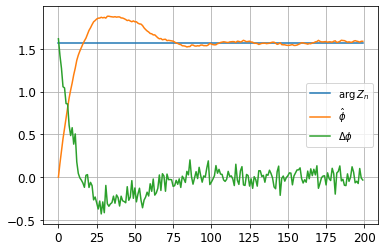

In [95]:
# plot phases
plt.plot(phase_error, label=r'$\arg Z_n$')
plt.plot(phi, label=r'$\hat{\phi}$')
plt.plot(dphi, label=r'$\Delta \phi$')

plt.grid()
plt.legend()

plt.show()

The estimated phase $\hat{\phi}$ converges to the true phase $\pi/2$.

Note also that the steady-state error is much smaller than the instantaneous phase error $\Delta \phi$.

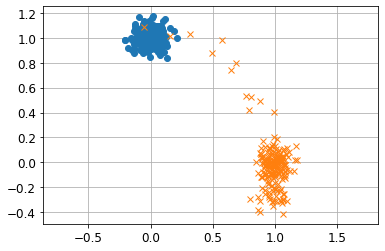

In [96]:
# Scatter plot of input before and after phase correcetion
plt.plot(Z.real, Z.imag, 'o', label='Before')
plt.plot(x.real, x.imag, 'x', label='After')
plt.grid()
plt.axis('equal')

plt.show()

After a few samples, the PLL succeeds in rotating the "constellation" to the correct location centered on the real axis.

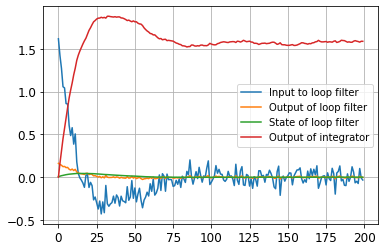

In [98]:
# plot internal signals
plt.plot(dphi, label="Input to loop filter")
plt.plot(y, label='Output of loop filter')
try:
    H.state
    plt.plot(state_H, label='State of loop filter')
except AttributeError:
    pass
plt.plot(phi, label='Output of integrator')

plt.grid()
plt.legend()
plt.show()

The output of the loop filter is a scaled and smoothed version of the input signal, i.e., the phase error $\Delta \phi$.

The state of the loop filter approaches zeros in steady state.

Recall that the output of the integrator (the phase estimate $\hat{\phi}$) is the obtained by integrating the output of the loop filter.

#### Response to a constant frequency error

The second phase error that we investigate is a ramp error: the phase of the input signal increases from $\pi/2$ to $\pi$ over the course of the observation. The (normalized) frequency offset is $\Delta f = \frac{1}{2\pi} \cdot \frac{\pi/2}{N} = \frac{1}{4N}$ per sample.

The second-order PLL is expected to learn this phase error and compenstate it.

In [102]:
# define phase error
phase_error = np.pi/2 * (1 + np.arange(N) / N)

# instantiate loop filter and integrator
H = Second_Order_Filter(alpha1, alpha2)
S = Integrator()

# make a received signal
Z = s * np.exp(1j * phase_error) + 1/np.sqrt(2*SNR) * (np.random.randn(N) + 1j * np.random.randn(N))

# run the PLL; intermediate signals are stored for analysis
for n in range(N):
    phi[n] = S.state
    x[n] = rotate_phase(Z[n], phi[n])
    dphi[n] = measure_phase(x[n], 1)
    y[n] = H(dphi[n])
    try:
        state_H[n] = H.state
    except AttributeError:
        pass
    S(y[n])

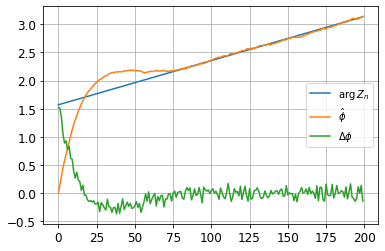

In [103]:
# plot phases
plt.plot(phase_error, label=r'$\arg Z_n$')
plt.plot(phi, label=r'$\hat{\phi}$')
plt.plot(dphi, label=r'$\Delta \phi$')

plt.grid()
plt.legend()

plt.show()

The estimated phase $\hat{\phi}$ rapidly converges to and tracks the phase of the input signal.

Again, the steady state error is much smaller than the instantaneous phase error.

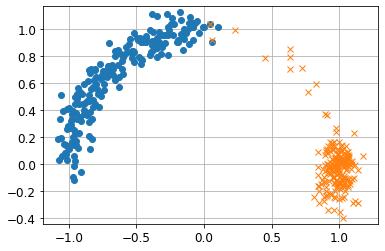

In [104]:
# Scatter plot of input before and after phase correcetion
plt.plot(Z.real, Z.imag, 'o', label='Before')
plt.plot(x.real, x.imag, 'x', label='After')
plt.grid()
plt.axis('equal')

plt.show()

After a few samples, the rotated "constellation" is centered correctly on the real axis.

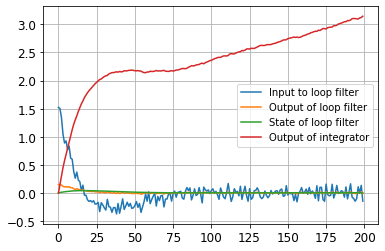

In [105]:
# plot internal signals
plt.plot(dphi, label="Input to loop filter")
plt.plot(y, label='Output of loop filter')
try:
    H.state
    plt.plot(state_H, label='State of loop filter')
except AttributeError:
    pass
plt.plot(phi, label='Output of integrator')

plt.grid()
plt.legend()
plt.show()

While the phase error (i.e., the input to the loop filter) approaches zero in state state, the output of the filter and the state of the filter do **not** approach zero. This is easier to see when the other signals are removed.

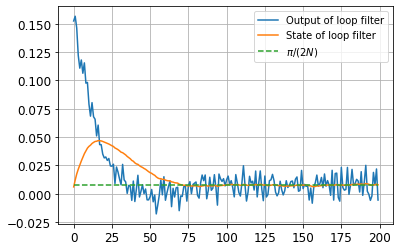

In [109]:
# close-up of loop-filter signals
plt.plot(y, label='Output of loop filter')
try:
    H.state
    plt.plot(state_H, label='State of loop filter')
except AttributeError:
    pass

plt.plot(np.arange(N), np.pi/2/N*np.ones(N), '--', label=r'$\pi/(2N)$')

plt.grid()
plt.legend()
plt.show()

The output of the loop filter and the state of the loop filter do not converge to zero when there is a frequency offset.

In fact, the state of the second-order loop filter approaches $2\pi \Delta f$ (i.e,. $\pi/(2N)$) in this case. This is the phase increase between consecutive samples in the input signal.

#### Response to a time-varying frequency error

The final phase error that we investigate is a time-varying error: the phase of the input signal increases from $0$ to $\pi$ and then back to $\pi/2$ over the course of the observation. The instantaneous normalized frequency of this signal varies between $1/(2N)$ initial to $-1/(2N)$ at the end.

The second-order PLL is expected to track this error fairly closely. However, it will not be able to eliminate t completely.

In [121]:
# define phase error
#phase_error = np.pi/2 * (1 + np.sin(np.pi*np.arange(N)/N))
phase_error = 2*np.pi/2 * (0 + np.sin(np.pi*np.arange(N)/N))

# instantiate loop filter and integrator
H = Second_Order_Filter(alpha1, alpha2)
S = Integrator()

# make a received signal
Z = s * np.exp(1j * phase_error) + 1/np.sqrt(2*SNR) * (np.random.randn(N) + 1j * np.random.randn(N))

# run the PLL; intermediate signals are stored for analysis
for n in range(N):
    phi[n] = S.state
    x[n] = rotate_phase(Z[n], phi[n])
    dphi[n] = measure_phase(x[n], 1)
    y[n] = H(dphi[n])
    try:
        state_H[n] = H.state
    except AttributeError:
        pass
    S(y[n])

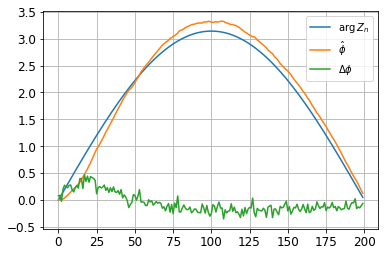

In [122]:
# plot phases
plt.plot(phase_error, label=r'$\arg Z_n$')
plt.plot(phi, label=r'$\hat{\phi}$')
plt.plot(dphi, label=r'$\Delta \phi$')

plt.grid()
plt.legend()

plt.show()

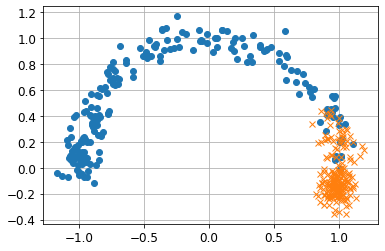

In [123]:
# Scatter plot of input before and after phase correcetion
plt.plot(Z.real, Z.imag, 'o', label='Before')
plt.plot(x.real, x.imag, 'x', label='After')
plt.grid()
plt.axis('equal')

plt.show()

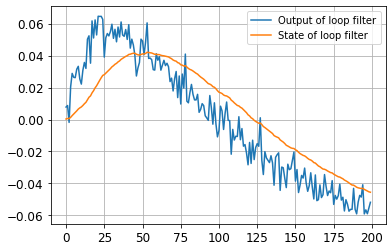

In [126]:
# close-up of loop-filter signals
plt.plot(y, label='Output of loop filter')
try:
    H.state
    plt.plot(state_H, label='State of loop filter')
except AttributeError:
    pass

plt.grid()
plt.legend()
plt.show()